initiate data
---------------------------------------------

In [ ]:
import pandas as pd
import numpy as np

data = pd.read_csv('rating.csv')

#https://hackersandslackers.com/pandas-dataframe-drop/

# print(data.shape)   #(7813737, 3)
# print(data.head(10))

# drop empty rows
data.dropna(
  axis=0,
  how='any',
  thresh=None,
  subset=None,
  inplace=True
)
# print(data.shape)      #(7813737, 3)
# print(data.head(10))



#drop duplicates
# print(data.duplicated().sum())     ** 1 duplicate removed
data = data.drop_duplicates()
# print(data.shape)               #(7813736, 3)
# print(data.head(10))



#drop rows without ratings
data = data[data.rating != -1]
# print(data.shape)           #(6337240, 3)
# print(data.head(10))
# print(7813736 - 6337240) #1476496 -1 removed



#drop users who have watch fewer than 10 movies (better to have more ratings per user for collaborative)
#drop movies watched by fewer than 10 users
animeIdSeries = data['anime_id'].value_counts()
userIdSeries = data['user_id'].value_counts()

# Remove inactive animies
data = data[data['anime_id'].isin(animeIdSeries[animeIdSeries > 10].index)]
# print(data.shape)
# print(data.head(10))
# print(6337240 - 6327710) #9530 inactive animies removed

# Remove inactive Users
data = data[data['user_id'].isin(userIdSeries[userIdSeries > 10].index)]
# print(data.shape)
# print(data.head(10))
# print(6327710 - 6259709)  #68001 inactive users removed



userID = data['user_id'].tolist()
animeID = data['anime_id'].tolist()
rate = data['rating'].tolist()

# data.to_csv("rating.csv", index=False)
print(data.shape)   #(6259709, 3)
print(data.head(10))


(6259709, 3)
     user_id  anime_id  rating
156        3        20       8
157        3       154       6
158        3       170       9
159        3       199      10
160        3       225       9
161        3       341       6
162        3       430       7
163        3       527       7
164        3       552       7
165        3       813      10


In [ ]:
#small datasets
# print(data.shape)

# Remove inactive animies
data = data[data['anime_id'].isin(animeIdSeries[animeIdSeries > 1800].index)]
# print(data.shape)
# print(data.head(10))
print(6259709-4442398) #1894842 inactive animies removed

# Remove inactive Users
data = data[data['user_id'].isin(userIdSeries[userIdSeries > 250].index)]
# print(data.shape)
# print(data.head(10))
print(4442398-1563620)  #68001 inactive users removed



userID = data['user_id'].tolist()
animeID = data['anime_id'].tolist()
rate = data['rating'].tolist()

# data.to_csv("rating.csv", index=False)
print(data.shape)   #(6259709, 3)
print(data.head(10))

1817311
2878778
(1563620, 3)
     user_id  anime_id  rating
302        5         6       8
303        5        15       6
306        5        20       6
307        5        22       5
308        5        24       1
309        5        30       1
310        5        45       7
311        5        47       8
312        5        57       7
313        5        63       1


Other recommendation engine 2: analyze anime.csv
-----------------------------------------------------------------------------------

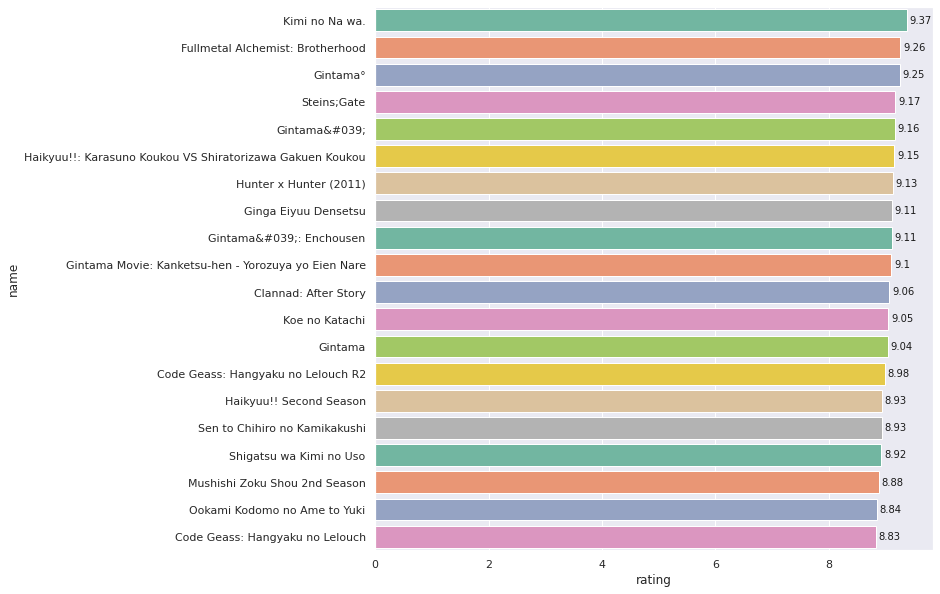

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

animeData = pd.read_csv('anime.csv')
top_anime = animeData[animeData['members'] > 50000]
top_anime = top_anime.sort_values(by='rating', ascending=False).head(20)
# print(top_anime.head(10))

sns.set(style="darkgrid")
plt.figure(figsize=(10, 10))

color = sns.color_palette("Set2")
ax = sns.barplot(x="rating", y="name", data=top_anime, palette=color)

for i in ax.patches:
    ax.text(i.get_width() + .05, i.get_y() + 0.5, str(i.get_width()), fontsize = 10, color = 'k')
plt.show()


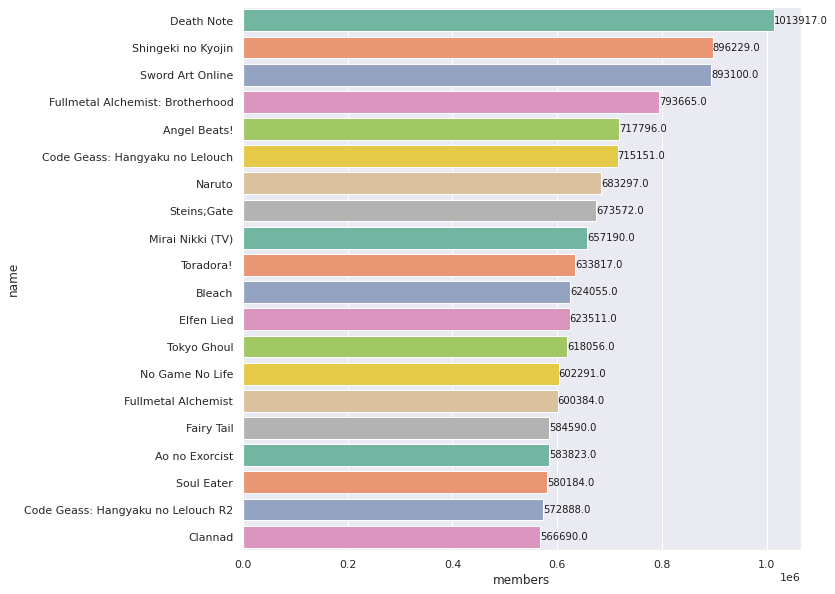

In [ ]:
top_vote = animeData.sort_values(by='members', ascending=False).head(20)
# print(top_vote.head(10))

sns.set(style="darkgrid")
plt.figure(figsize=(10, 10))

color = sns.color_palette("Set2")
ax = sns.barplot(x="members", y="name", data=top_vote, pa   lette=color)

for i in ax.patches:
    ax.text(i.get_width() + .05, i.get_y() + 0.5, str(i.get_width()), fontsize = 10, color = 'k')
plt.show()

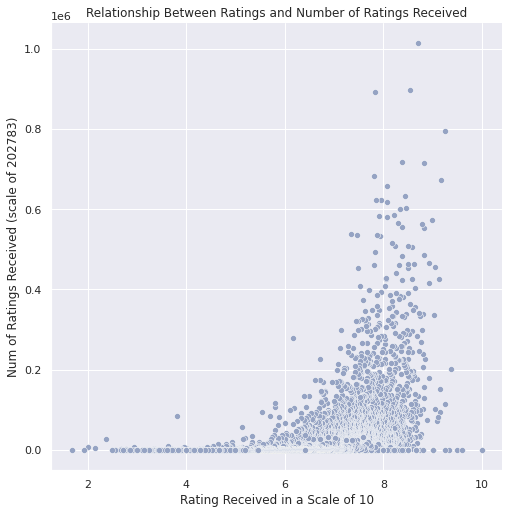

In [ ]:
ax = sns.relplot(data=animeData, x="rating", y="members", kind = "scatter", color = '#95a3c3', sizes=(100, 200), height=7, marker='o')

ax.set(xlabel='Rating Received in a Scale of 10',
       ylabel='Num of Ratings Received (scale of 202783)',
       title='Relationship Between Ratings and Number of Ratings Received')

indicating that there are no strong relationships between the rating a book receives and meta-variables (like rating counts etc.). This means that the rating depends more strongly on other features (e.g. the quality of the books itself).

no correlation between rating and members

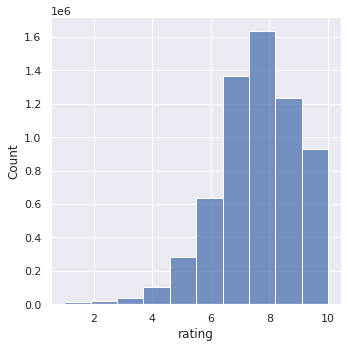

In [ ]:
sns.displot(data, x="rating", bins=10)

Other recommendation engine 4:
---------------------------------------------------
Pivot table, collaborative filtering, the same dataset


In [ ]:
import pandas as pd
import numpy as np
import scipy as sp
from sklearn.metrics.pairwise import cosine_similarity
import operator
%matplotlib inline

In [ ]:
anime = pd.read_csv('anime.csv')
rating = pd.read_csv('rating.csv')

In [ ]:

#Before alteration the ratings dataset uses a "-1" to represent missing ratings. I'm replacing these placeholders with a null value because I will later be calculating the average rating per user and don't want the average to be distorted

rating.rating.replace({-1: np.nan}, regex=True, inplace = True)
rating.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [ ]:
# finding recommendations for only the TV category

anime_tv = anime[anime['type']=='TV']
anime_tv.head()

,anime_id,name,genre,type,episodes,rating,members
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
5,32935,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...,"Comedy, Drama, School, Shounen, Sports",TV,10,9.15,93351


In [ ]:
# Join the two dataframes on the anime_id columns

merged = rating.merge(anime_tv, left_on = 'anime_id', right_on = 'anime_id', suffixes= ['_user', ''])
merged.rename(columns = {'rating_user':'user_rating'}, inplace = True)
merged.head()

,user_id,anime_id,user_rating,name,genre,type,episodes,rating,members
0,1,20,-1,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297
1,3,20,8,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297
2,5,20,6,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297
3,6,20,-1,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297
4,10,20,-1,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297


In [ ]:
# For computing reasons I'm limiting the dataframe length to 10,000 users

merged=merged[['user_id', 'name', 'user_rating']]
merged_sub= merged[merged.user_id <= 10000]
merged_sub.head()

,user_id,name,user_rating
0,1,Naruto,-1
1,3,Naruto,8
2,5,Naruto,6
3,6,Naruto,-1
4,10,Naruto,-1


In [ ]:
#For collaborative filtering we'll need to create a pivot table of users on one axis and tv show names along the other.
#The pivot table will help us in defining the similarity between users and shows to better predict who will like what.

piv = merged_sub.pivot_table(index=['user_id'], columns=['name'], values='user_rating')
print(piv.shape)
piv.head()

(9936, 2804)


name,.hack//Roots,.hack//Sign,.hack//Tasogare no Udewa Densetsu,009-1,07-Ghost,11eyes,12-sai.: Chicchana Mune no Tokimeki,3 Choume no Tama: Uchi no Tama Shirimasenka?,30-sai no Hoken Taiiku,91 Days,A-Channel,A.D. Police (TV),AKB0048,AKB0048: Next Stage,Aa Harimanada,Aa! Megami-sama! (TV),Aa! Megami-sama!: Chichaitte Koto wa Benri da ne,Aa! Megami-sama!: Sorezore no Tsubasa,Abarenbou Rikishi!! Matsutarou,Abenobashi Mahou☆Shoutengai,Absolute Duo,Accel World,Acchi Kocchi (TV),Ace wo Nerae!,Active Raid: Kidou Kyoushuushitsu Dai Hachi Gakari,Active Raid: Kidou Kyoushuushitsu Dai Hachi Gakari 2nd,Afro Samurai,After War Gundam X,Agatha Christie no Meitantei Poirot to Marple,Ai Shoujo Pollyanna Story,Ai Tenchi Muyou!,Ai Tenshi Densetsu Wedding Peach,Ai Yori Aoshi,Ai Yori Aoshi: Enishi,Ai no Gakko Cuore Monogatari,Ai no Wakakusa Monogatari,Ai to Yuuki no Pig Girl Tonde Buurin,Aikatsu!,Air,Air Gear,...,Yu☆Gi☆Oh! 5D&#039;s,Yu☆Gi☆Oh! Duel Monsters,Yu☆Gi☆Oh! Zexal,Yu☆Gi☆Oh! Zexal Second,Yu☆Gi☆Oh!: Duel Monsters GX,Z/X: Ignition,Zan Sayonara Zetsubou Sensei,Zankyou no Terror,Zegapain,Zenryoku Usagi,Zero Duel Masters,Zero no Tsukaima,Zero no Tsukaima F,Zero no Tsukaima: Futatsuki no Kishi,Zero no Tsukaima: Princesses no Rondo,Zetman,Zetsuen no Tempest,Zettai Bouei Leviathan,Zettai Karen Children,Zettai Karen Children: The Unlimited - Hyoubu Kyousuke,Zettai Muteki Raijin-Oh,Zettai Shounen,Zipang,Zoids,Zoids Fuzors,Zoids Genesis,Zoids Shinseiki/Zero,Zoku Natsume Yuujinchou,Zoku Sayonara Zetsubou Sensei,Zombie-Loan,"Zone of the Enders: Dolores, I",Zukkoke Knight: Don De La Mancha,ef: A Tale of Melodies.,ef: A Tale of Memories.,gdgd Fairies,gdgd Fairies 2,iDOLM@STER Xenoglossia,s.CRY.ed,xxxHOLiC,xxxHOLiC Kei
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3.0,NaN,NaN,5.0,NaN,7.0,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN


In [ ]:
# Note: As we are subtracting the mean from each rating to standardize
# all users with only one rating or who had rated everything the same will be dropped

# Normalize the values
piv_norm = piv.apply(lambda x: (x-np.mean(x))/(np.max(x)-np.min(x)), axis=1)


# Drop all columns containing only zeros representing users who did not rate
piv_norm.fillna(0, inplace=True)
piv_norm = piv_norm.T
piv_norm = piv_norm.loc[:, (piv_norm != 0).any(axis=0)]

In [ ]:
# Our data needs to be in a sparse matrix format to be read by the following functions

piv_sparse = sp.sparse.csr_matrix(piv_norm.values)

In [ ]:
item_similarity = cosine_similarity(piv_sparse)
user_similarity = cosine_similarity(piv_sparse.T)

In [ ]:
# Inserting the similarity matricies into dataframe objects

item_sim_df = pd.DataFrame(item_similarity, index = piv_norm.index, columns = piv_norm.index)
user_sim_df = pd.DataFrame(user_similarity, index = piv_norm.columns, columns = piv_norm.columns)

In [ ]:
# This function will return the top 10 shows with the highest cosine similarity value

def top_animes(anime_name):
    count = 1
    print('Similar shows to {} include:\n'.format(anime_name))
    for item in item_sim_df.sort_values(by = anime_name, ascending = False).index[1:11]:
        print('No. {}: {}'.format(count, item))
        count +=1

In [ ]:
# This function will return the top 5 users with the highest similarity value

def top_users(user):

    if user not in piv_norm.columns:
        return('No data available on user {}'.format(user))

    print('Most Similar Users:\n')
    sim_values = user_sim_df.sort_values(by=user, ascending=False).loc[:,user].tolist()[1:11]
    sim_users = user_sim_df.sort_values(by=user, ascending=False).index[1:11]
    zipped = zip(sim_users, sim_values,)
    for user, sim in zipped:
        print('User #{0}, Similarity value: {1:.2f}'.format(user, sim))

In [ ]:
# This function constructs a list of lists containing the highest rated shows per similar user
# and returns the name of the show along with the frequency it appears in the list

def similar_user_recs(user):

    if user not in piv_norm.columns:
        return('No data available on user {}'.format(user))

    sim_users = user_sim_df.sort_values(by=user, ascending=False).index[1:11]
    best = []
    most_common = {}

    for i in sim_users:
        max_score = piv_norm.loc[:, i].max()
        best.append(piv_norm[piv_norm.loc[:, i]==max_score].index.tolist())
    for i in range(len(best)):
        for j in best[i]:
            if j in most_common:
                most_common[j] += 1
            else:
                most_common[j] = 1
    sorted_list = sorted(most_common.items(), key=operator.itemgetter(1), reverse=True)
    return sorted_list[:5]

In [ ]:
# This function calculates the weighted average of similar users
# to determine a potential rating for an input user and show

def predicted_rating(anime_name, user):
    sim_users = user_sim_df.sort_values(by=user, ascending=False).index[1:1000]
    user_values = user_sim_df.sort_values(by=user, ascending=False).loc[:,user].tolist()[1:1000]
    rating_list = []
    weight_list = []
    for j, i in enumerate(sim_users):
        rating = piv.loc[i, anime_name]
        similarity = user_values[j]
        if np.isnan(rating):
            continue
        elif not np.isnan(rating):
            rating_list.append(rating*similarity)
            weight_list.append(similarity)
    return sum(rating_list)/sum(weight_list)

In [ ]:
top_animes('Cowboy Bebop')

Similar shows to Cowboy Bebop include:

No. 1: Samurai Champloo
No. 2: Tengen Toppa Gurren Lagann
No. 3: Neon Genesis Evangelion
No. 4: Black Lagoon
No. 5: Great Teacher Onizuka
No. 6: Trigun
No. 7: Black Lagoon: The Second Barrage
No. 8: Baccano!
No. 9: Fullmetal Alchemist: Brotherhood
No. 10: Ghost in the Shell: Stand Alone Complex


In [ ]:
top_users(3)

Most Similar Users:

User #4647, Similarity value: 0.55
User #2277, Similarity value: 0.54
User #3225, Similarity value: 0.47
User #934, Similarity value: 0.41
User #1406, Similarity value: 0.38
User #6563, Similarity value: 0.38
User #4037, Similarity value: 0.36
User #1038, Similarity value: 0.35
User #9577, Similarity value: 0.35
User #3028, Similarity value: 0.32


In [ ]:
similar_user_recs(3)

[('Fullmetal Alchemist: Brotherhood', 7),
 ('Shingeki no Kyojin', 4),
 ('Toradora!', 3),
 ('Kiseijuu: Sei no Kakuritsu', 3),
 ('Akame ga Kill!', 2)]

In [ ]:
predicted_rating('Cowboy Bebop', 3)

8.06794597380504

--------------------------------------------------------

load panda dataframe
--------------------------------------------

In [ ]:
!pip install scikit-surprise
from surprise import Dataset
from surprise import Reader


ratings_dict = {
  "item": animeID,
  "user": userID,
  "rating": rate,
}

df = pd.DataFrame(ratings_dict)
# print(df)
reader = Reader(rating_scale=(1, 10))


#loads pandas dataframe
data = Dataset.load_from_df(df[["user", "item", "rating"]], reader)

#loads the builtin MOvielens-100k data
# movielens = Dataset.load_builtin('ml-100k')
# http://surpriselib.com/

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


K-nearest model (cosine)
-----------------------------------------------

In [ ]:
from surprise import KNNWithMeans
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate


# trainset, testset = train_test_split(data, test_size=.25)

#To use item-based cosine similarity
sim_options = {
  "name": "cosine",
  "user_based": False, #find similarities between items
}
algo = KNNWithMeans(sim_options=sim_options)

# algo.fit(trainset)
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# predictions = algo.test(testset)

# # Then compute RMSE
# accuracy.rmse(predictions)

# # Then compute MAE
# accuracy.mae(predictions)

# #TRAIN model
# trainingSet = data.build_full_trainset()
# algo.fit(trainingSet)

# predicted = algo.predict(testSet)
draw_confusion_matrix(predicted, testSet, ['Fake', 'True'])

# prediction.est

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0928  1.0895  1.0904  1.0922  1.0946  1.0919  0.0018  
MAE (testset)     0.8256  0.8226  0.8227  0.8230  0.8246  0.8237  0.0012  
Fit time          14.50   14.27   13.91   15.05   13.72   14.29   0.47    
Test time         100.45  87.55   86.54   88.73   88.64   90.38   5.10    


{'test_rmse': array([1.09277243, 1.08945772, 1.09035998, 1.09223711, 1.09456591]),
 'test_mae': array([0.82557911, 0.82257493, 0.82272894, 0.82303062, 0.82459537]),
 'fit_time': (14.50347900390625,
  14.271815061569214,
  13.911585330963135,
  15.045344829559326,
  13.71623182296753),
 'test_time': (100.44956612586975,
  87.54612803459167,
  86.54366993904114,
  88.73291850090027,
  88.64050316810608)}

In [ ]:
# predictions = algo.test(testset)

# # Then compute RMSE
# accuracy.rmse(predictions)
# Then compute MAE
accuracy.mae(predictions)

MAE:  0.8884


0.8883618742366253

K-nearest model (msd)
-----------------------------------------------

In [ ]:
from surprise import KNNWithMeans
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate


trainset, testset = train_test_split(data, test_size=.25)

#To use item-based cosine similarity
sim_options = {
  "name": "msd",
  "min_support": 5,
  "user_based": False, #find similarities between items
}
algo = KNNWithMeans(sim_options=sim_options)
algo.fit(trainset)

# cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)



predictions = algo.test(testset)

# # Then compute RMSE
accuracy.rmse(predictions)
# #execution time RMSE: 9m 36s  RMSE: 1.1621

# # Then compute MAE
# accuracy.mae(predictions)

# #TRAIN model
# trainingSet = data.build_full_trainset()
# algo.fit(trainingSet)

# prediction = algo.predict(25, 20787)
# prediction.est

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0832  1.0844  1.0882  1.0820  1.0872  1.0850  0.0023  
MAE (testset)     0.8150  0.8169  0.8184  0.8150  0.8177  0.8166  0.0014  
Fit time          10.50   11.16   11.42   11.36   11.30   11.15   0.33    
Test time         102.69  102.17  102.66  102.43  101.82  102.36  0.33    


{'fit_time': (10.500980138778687,
  11.163866758346558,
  11.417117595672607,
  11.356464624404907,
  11.29641342163086),
 'test_mae': array([0.81496837, 0.81685263, 0.81839657, 0.81498517, 0.817666  ]),
 'test_rmse': array([1.08323019, 1.08440193, 1.08820943, 1.08203895, 1.08724668]),
 'test_time': (102.69285082817078,
  102.17233085632324,
  102.66315937042236,
  102.42883634567261,
  101.81922960281372)}

In [ ]:
# predictions = algo.test(testset)

# # # Then compute RMSE
# # accuracy.rmse(predictions)
# # Then compute MAE
# accuracy.mae(predictions)

prediction = algo.predict(25, 20787)
prediction.est

7.406113004352914

KNNBasic
---------------------------------------------

In [ ]:
from surprise import KNNBasic
from surprise import accuracy
from surprise.model_selection import cross_validate


#To use item-based cosine similarity
sim_options = {
  "name": "msd",
  "min_support": 5,
  "user_based": False, #find similarities between items
}
algo = KNNBasic(sim_options=sim_options)
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)



# predictions = algo.test(testset)

# # Then compute RMSE
# accuracy.rmse(predictions)
# #execution time RMSE: 9m 36s  RMSE: 1.1621

# # Then compute MAE
# accuracy.mae(predictions)

# #TRAIN model
# trainingSet = data.build_full_trainset()
# algo.fit(trainingSet)

# prediction = algo.predict(25, 20787)
# prediction.est

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.1006  1.1025  1.1018  1.1042  1.1041  1.1026  0.0014  
MAE (testset)     0.8286  0.8293  0.8292  0.8305  0.8309  0.8297  0.0008  
Fit time          9.51    10.22   10.02   10.54   10.12   10.08   0.34    
Test time         100.67  98.29   101.63  98.35   102.09  100.21  1.61    


{'fit_time': (9.508226871490479,
  10.221405506134033,
  10.022903680801392,
  10.539912700653076,
  10.121744871139526),
 'test_mae': array([0.82862026, 0.82934477, 0.82915679, 0.83049423, 0.83085445]),
 'test_rmse': array([1.10056758, 1.10246311, 1.10179841, 1.10418123, 1.10406024]),
 'test_time': (100.66896295547485,
  98.28871321678162,
  101.6349868774414,
  98.34880018234253,
  102.09240531921387)}

KNNWithZScore
--------------------------------------------

what is it comparing by passing in the entire dataset, what is the y?
predict how each anime close to each other
In the cross validation, predict the rating that the user will give to a certain anime?

how to make it into a recommendation system using the best a

In [ ]:
from surprise import KNNWithZScore
from surprise import accuracy
from surprise.model_selection import cross_validate


#To use item-based cosine similarity
sim_options = {
  "name": "msd",
  "min_support": 5,
  "user_based": False, #find similarities between items
}
algo = KNNWithZScore(sim_options=sim_options)
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)



# predictions = algo.test(testset)

# # Then compute RMSE
# accuracy.rmse(predictions)
# #execution time RMSE: 9m 36s  RMSE: 1.1621

# # Then compute MAE
# accuracy.mae(predictions)

# #TRAIN model
# trainingSet = data.build_full_trainset()
# algo.fit(trainingSet)

# prediction = algo.predict(25, 20787)
# prediction.est

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithZScore on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0887  1.0863  1.0886  1.0902  1.0887  1.0885  0.0012  
MAE (testset)     0.8179  0.8156  0.8180  0.8175  0.8172  0.8172  0.0009  
Fit time          11.07   13.16   12.96   13.66   13.01   12.77   0.89    
Test time         109.48  110.97  109.78  109.49  108.78  109.70  0.72    


{'fit_time': (11.065867185592651,
  13.157791137695312,
  12.961036682128906,
  13.664770126342773,
  13.006183862686157),
 'test_mae': array([0.81788617, 0.81557721, 0.81799381, 0.81747592, 0.81721713]),
 'test_rmse': array([1.08867179, 1.08628838, 1.08862556, 1.09017085, 1.08867259]),
 'test_time': (109.48345279693604,
  110.97160458564758,
  109.78085422515869,
  109.48860359191895,
  108.78016543388367)}

KNNBaseline
---------------------------------------------------------------

In [ ]:
from surprise import KNNBaseline
from surprise import accuracy
from surprise.model_selection import cross_validate


#To use item-based cosine similarity
sim_options = {
  "name": "pearson_baseline",
  "min_support": 5,
  "user_based": False, #find similarities between items
}
algo = KNNBaseline(sim_options=sim_options)

cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)



# predictions = algo.test(testset)

# # Then compute RMSE
# accuracy.rmse(predictions)
# #execution time RMSE: 9m 36s  RMSE: 1.1621

# # Then compute MAE
# accuracy.mae(predictions)

# #TRAIN model
# trainingSet = data.build_full_trainset()
# algo.fit(trainingSet)

# prediction = algo.predict(25, 20787)
# prediction.est

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBaseline on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0984  1.0969  1.0966  1.0977  1.0978  1.0975  0.0007  
MAE (testset)     0.8199  0.8191  0.8186  0.8191  0.8192  0.8191  0.0004  
Fit time          172.82  194.44  186.78  198.86  198.53  190.28  9.76    
Test time         441.81  487.32  463.30  494.67  490

{'fit_time': (172.81557416915894,
  194.44050884246826,
  186.77885055541992,
  198.8563687801361,
  198.5285987854004),
 'test_mae': array([0.81989468, 0.8190523 , 0.8185735 , 0.81907582, 0.81915047]),
 'test_rmse': array([1.09839923, 1.09686121, 1.09660392, 1.09769777, 1.09781553]),
 'test_time': (441.81091356277466,
  487.3217308521271,
  463.3038823604584,
  494.66745948791504,
  490.0440456867218)}

In [ ]:
from surprise import KNNBaseline
from surprise import accuracy
from surprise.model_selection import cross_validate


#To use item-based cosine similarity
sim_options = {
  "name": "pearson_baseline",
  "min_support": 5,
  "user_based": False, #find similarities between items
}

bsl_options = {
  'method': 'als',
  'n_epochs': 5,
  'reg_u': 20,
  'reg_i': 15,
}
algo = KNNBaseline(sim_options=sim_options, bsl_options=bsl_options)

cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBaseline on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0339  1.0331  1.0330  1.0332  1.0310  1.0328  0.0010  
MAE (testset)     0.7751  0.7754  0.7746  0.7745  0.7734  0.7746  0.0007  
Fit time          22.93   24.43   24.31   24.36   24.14   24.03   0.56    
Test time         116.46  114.88  115.31  116.87  113

{'fit_time': (22.930623531341553,
  24.42544960975647,
  24.307349681854248,
  24.362988710403442,
  24.13756775856018),
 'test_mae': array([0.77512342, 0.77541338, 0.77461677, 0.77445745, 0.77341176]),
 'test_rmse': array([1.03388892, 1.03308542, 1.03299629, 1.03315533, 1.03100433]),
 'test_time': (116.46276497840881,
  114.88251638412476,
  115.31481981277466,
  116.86981201171875,
  113.72049951553345)}

SVD Model
------------------------------------------------------------------------

In [ ]:
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate

reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(df[["user", "item", "rating"]], reader)
algo = SVD()
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# #TRAIN model
# trainingSet = data.build_full_trainset()
# algo.fit(trainingSet)

# prediction = algo.predict(25, 20787)
# prediction.est

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.1264  1.1266  1.1271  1.1276  1.1253  1.1266  0.0008  
MAE (testset)     0.8420  0.8419  0.8425  0.8423  0.8419  0.8421  0.0002  
Fit time          316.44  318.06  314.84  313.94  315.13  315.68  1.43    
Test time         31.23   27.90   24.22   28.12   23.87   27.07   2.74    


{'fit_time': (316.4447457790375,
  318.05599093437195,
  314.8350443840027,
  313.9383943080902,
  315.1267263889313),
 'test_mae': array([0.84201333, 0.84190124, 0.84250391, 0.84230886, 0.84191166]),
 'test_rmse': array([1.12641691, 1.12658008, 1.1270893 , 1.12762865, 1.1252614 ]),
 'test_time': (31.232650995254517,
  27.899654626846313,
  24.2162606716156,
  28.12494730949402,
  23.867344617843628)}

In [ ]:
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate

# trainset, testset = train_test_split(data, test_size=.25)
algo = SVD()
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)


trainset = data.build_full_trainset()
algo.fit(trainset)

cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# algo.fit(trainset)
# predictions = algo.test(testset)

# # Then compute RMSE
# accuracy.rmse(predictions)
# # Execution time: 5m 57s, RMSE: 1.1349

# # Then compute MAE
# accuracy.mae(predictions)
# # Execution time: 5m 53s, RMSE: 0.8478

# #TRAIN model
# trainingSet = data.build_full_trainset()
# algo.fit(trainingSet)

# prediction = algo.predict(25, 20787)
# prediction.est

KeyboardInterrupt: ignored

In [ ]:
algo.fit(trainset)

cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0475  1.0518  1.0501  1.0496  1.0507  1.0499  0.0014  
MAE (testset)     0.7853  0.7887  0.7872  0.7870  0.7873  0.7871  0.0011  
Fit time          75.07   75.78   76.11   76.05   76.53   75.91   0.48    
Test time         5.56    4.99    5.17    5.75    5.10    5.31    0.29    


{'fit_time': (75.07451796531677,
  75.7825071811676,
  76.11298680305481,
  76.04747891426086,
  76.52914094924927),
 'test_mae': array([0.78531359, 0.78866118, 0.78719797, 0.78698643, 0.78725707]),
 'test_rmse': array([1.04746462, 1.05175267, 1.05009363, 1.04964395, 1.05070208]),
 'test_time': (5.556574583053589,
  4.987641334533691,
  5.1677470207214355,
  5.748677968978882,
  5.095146417617798)}

NMF model
----------------------------------------

In [ ]:
from surprise import NMF
from surprise import Dataset
from surprise.model_selection import cross_validate

reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(df[["user", "item", "rating"]], reader)
algo = NMF()
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# #TRAIN model
# trainingSet = data.build_full_trainset()
# algo.fit(trainingSet)

# prediction = algo.predict(25, 20787)
# prediction.est

Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    2.2172  2.1793  2.1939  2.1924  2.2031  2.1972  0.0126  
MAE (testset)     1.9824  1.9436  1.9591  1.9571  1.9679  1.9620  0.0128  
Fit time          87.94   92.40   90.58   91.70   90.85   90.69   1.52    
Test time         5.01    4.93    4.92    4.52    4.29    4.74    0.28    


{'fit_time': (87.94349908828735,
  92.39586281776428,
  90.5827853679657,
  91.69657635688782,
  90.84804177284241),
 'test_mae': array([1.98237226, 1.94364399, 1.95909673, 1.95706721, 1.96786583]),
 'test_rmse': array([2.21715437, 2.17926753, 2.19389188, 2.19236082, 2.20312425]),
 'test_time': (5.010337829589844,
  4.932870864868164,
  4.917050123214722,
  4.522629976272583,
  4.293063640594482)}

Slope One algorithm
------------------------------------------------------------

In [ ]:
from surprise import SlopeOne
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate


# trainset, testset = train_test_split(data, test_size=.25)
algo = SlopeOne()

algo.fit(trainset)
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
# predictions = algo.test(testset)

# # Then compute RMSE
# accuracy.rmse(predictions)
# #RMSE: 1.1924  Execution time: 9m 34s

# # Then compute MAE
# accuracy.mae(predictions)
# # Execution time: 9m 8s, MAE: 0.9027


# #TRAIN model
# trainingSet = data.build_full_trainset()
# algo.fit(trainingSet)
# prediction = algo.predict(25, 20787)
# prediction.est

Evaluating RMSE, MAE of algorithm SlopeOne on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.1324  1.1401  1.1367  1.1351  1.1345  1.1357  0.0026  
MAE (testset)     0.8584  0.8626  0.8609  0.8584  0.8589  0.8598  0.0016  
Fit time          14.50   15.76   15.38   15.45   15.53   15.32   0.43    
Test time         81.14   80.99   80.66   81.32   81.44   81.11   0.27    


{'fit_time': (14.500823736190796,
  15.759157419204712,
  15.381051301956177,
  15.44687533378601,
  15.533745527267456),
 'test_mae': array([0.85840591, 0.86258954, 0.86085975, 0.85844525, 0.85890557]),
 'test_rmse': array([1.1323597 , 1.14010771, 1.13671506, 1.13507361, 1.13445594]),
 'test_time': (81.14400100708008,
  80.99327731132507,
  80.66094851493835,
  81.31528329849243,
  81.44366455078125)}

In [ ]:
predictions = algo.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)
#RMSE: 1.1924  Execution time: 9m 34s

RMSE: 1.1947


1.194735703810057

CoClustering algorithm
-----------------------------------------------------------------

In [ ]:
from surprise import CoClustering
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate


trainset, testset = train_test_split(data, test_size=.25)
algo = CoClustering()

algo.fit(trainset)
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# predictions = algo.test(testset)

# # Then compute RMSE
# accuracy.rmse(predictions)
# #Execution time: 4m 59s, RMSE: 1.2033

# # Then compute MAE
# accuracy.mae(predictions)
# #Execution time: 5m 1s, MAE: 0.9120

# #TRAIN model
# trainingSet = data.build_full_trainset()
# algo.fit(trainingSet)
# prediction = algo.predict(25, 20787)
# prediction.est

ModuleNotFoundError: ignored

build something like that, lots of options to find the similarities.
K-nearest model
try different model, see the results, compare, find the best one

K-nearest algorithm to answer the second research questions





In [ ]:
from surprise import KNNWithMeans
from surprise import Dataset
from surprise.model_selection import GridSearchCV  #test the accuracy

reader = Reader(rating_scale=(1, 10))
# data = Dataset.load_from_file('rating.csv', reader)
data = Dataset.load_from_df(df[["user", "item", "rating"]], reader)


sim_options = {
    "name": ["msd", "cosine"],
    "min_support": [3, 4, 5],
    "user-based": [False, True],
}

param_grid = {"sim_options": sim_options}

gs = GridSearchCV(KNNWithMeans, param_grid, measures=["rmse", "mae"], cv=3)


gs.fit(data)

print(gs.best_score["rmse"])
print(gs.best_params["rmse"])

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi